In [77]:
# Import the packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import plotly.express as px
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
tf.random.set_seed(1)

In [12]:
df = pd.read_excel('/content/drive/MyDrive/Github/m_tech/Datasets/input.xlsx')

In [15]:
df.head()

,SalesVolume
Date,
1995-01-01,47639
1995-02-01,47880
1995-03-01,67025
1995-04-01,56925
1995-05-01,64192


In [14]:
df = df.dropna()
df = df.sort_values('Date').set_index('Date')
# df['Date'] = pd.DatetimeIndex(df['Date'])
# df = df.groupby('Date').sum()
# #Settting a Monthly frequency and also to the first day of the month
# df = df.asfreq('MS')

In [16]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(df.values.reshape(len(df), 1))
series = pd.DataFrame(scaled)

In [17]:
def create_samples(window_size,series):
  series_s = series.copy()
  for i in range(window_size):
    series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)
  series.dropna(axis=0, inplace=True)
  return series

In [18]:
lstm_input = create_samples(12, series)

In [20]:
def create_train_samples(sample_series):
  train_X = sample_series.iloc[:,:-1].values
  train_y = sample_series.iloc[:,-1].values
  train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
  return train_X, train_y

In [21]:
train_X, train_y = create_train_samples(lstm_input)

In [25]:
def base_model(train_X):
  model_arch = Sequential()
  model_arch.add(LSTM(128, activation= 'relu', return_sequences= False,input_shape=(train_X.shape[1], 1),
                 kernel_initializer= 'lecun_uniform',kernel_regularizer= 'l2'))
  model_arch.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate= 0.001)
  model_arch.compile(loss="mse", optimizer= opt)
  return model_arch

In [26]:
univariate_forecast_model = base_model(train_X)

In [84]:
def fit_model(model_arch, train_X, train_y, batch_size):
  model_arch.fit(train_X,
                 train_y,
                 batch_size=batch_size,
                 epochs=100,
                 validation_data=(train_X,train_y),
                 callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

In [ ]:
fit_model(univariate_forecast_model, train_X, train_y, 32)

In [86]:
def moving_test_window_preds(scaled_dataset, window_size, model, n_future_preds, scaler):
    ''' n_future_preds - number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []
    # moving_test_window = [train_X[len(train_X) - 1, :].tolist()]
    # moving_test_window = np.array(moving_test_window)
    moving_test_window = scaled_dataset[-window_size:].values.reshape(1,window_size,1)

    for i in range(n_future_preds):
      preds_one_step = model.predict(moving_test_window)
      preds_moving.append(preds_one_step[0, 0])
      preds_one_step = preds_one_step.reshape(1, 1, 1)
      moving_test_window = np.concatenate((moving_test_window[:, 1:, :], preds_one_step), axis=1)
    preds_moving = scaler.inverse_transform(np.array(preds_moving).reshape(n_future_preds, 1))
    preds_moving = preds_moving[1:]
    return preds_moving

In [87]:
predictions = moving_test_window_preds(series, 12, univariate_forecast_model,
                                                   24, scaler)

In [88]:
def create_future_dataframe(dataset,forecast_range,future_freq,predictions):
  last_date = dataset.index[-1]  # need to be change (to get next day of last_date)
  data = pd.date_range(last_date, periods = forecast_range-1,freq = future_freq)
  col = {'Date':data}
  pred_df = pd.DataFrame(data = col)
  pred_df['SalesVolume'] = predictions
  return pred_df

In [89]:
forecasted_dataset = create_future_dataframe(df, 24, 'MS', predictions)

In [90]:
forecasted_dataset.head()

,Date,SalesVolume
0,2021-08-01,34395.007812
1,2021-09-01,26557.304688
2,2021-10-01,19381.412109
3,2021-11-01,9264.495117
4,2021-12-01,1041.238525


In [91]:
final_df = df.reset_index().append(forecasted_dataset[1:])

In [92]:
final_df.tail()

,Date,SalesVolume
18,2023-02-01,85951.898438
19,2023-03-01,92253.843750
20,2023-04-01,97253.359375
21,2023-05-01,102970.742188
22,2023-06-01,96977.187500


In [93]:
fig = px.line(final_df, x='Date', y="SalesVolume")
fig.show()

In [94]:
final_df['Date'] = pd.DatetimeIndex(final_df['Date'])
final_df = final_df.groupby('Date').sum()

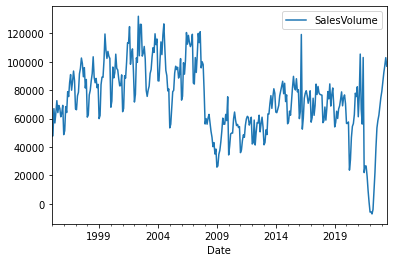

In [95]:
final_df.plot()